# Step 1: Compression and Vectorization of Songs

References: 

https://github.com/shubham3121/music-generation-using-rnn 

https://www.hackerearth.com/blog/developers/jazz-music-using-deep-learning/

https://pyguitarpro.readthedocs.io/en/stable/index.html

## Imports

In [1]:
import cv2 as cv
from glob import glob
from guitarpro import *
import guitarpro
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
from tqdm import tqdm

from keras.utils import np_utils

from _Compressor import compress_track
from _Decompressor import decompress_track

## Constants

In [2]:
MIDI  = {str(GuitarString(number=0, value=val)) : val for val in range(128)}

## Choose Songs (Make sure to convert to 4/4 before running)

In [3]:
# Choose a certain cohort of songs

#filenames = glob('metallica-*.gp*')
#filenames = glob('korn-*.gp*') + glob('metallica-*.gp*') + glob('slayer-*.gp*')
filenames = glob('slayer-*.gp*') + glob('sepultura-*.gp*')
#filenames = glob('slipknot-*gp*') + glob('linkin_park-*gp*')

#filenames = [file for file in glob('*.gp*') if file[0] != '_']

## Compress Each Track

In [4]:
compressed_tracks = []

for filename in tqdm(filenames):
    song = guitarpro.parse(filename)
    
    for track in song.tracks:
        #print(track.name, track.channel.instrument)
        if track.isPercussionTrack:
        #    print('\tskip')
            continue
            
        compressed_track = compress_track(track)

        # Ignore the current track if it only contains rests.
        if all(all(beat[0] == 'rest' for beat in measure) for measure in compressed_track):
        #    print('\tskip')
            continue
            
        compressed_tracks.append(compressed_track)
        

print(f'Number of tracks: {len(compressed_tracks)}')

#[print(track.name) for track in tracks]

100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

Number of tracks: 47


## Compile Note Vocabulary

In [5]:
notes = []
notes_set = set()

for compressed_track in tqdm(compressed_tracks):
 
    # Add each beat's note to the notes list.
    for measure in compressed_track:
        
        keep = True
        
        # Skip measures that are only rests.
        # TODO: Consider only removing rest measures that occur at least twice in a row.
        if all(beat[0] == 'rest' for beat in measure):
            keep = False
        
        for beat in measure:
            notes_set.add(beat)
            if keep:
                notes.append(beat)
                
                
notes_set = notes_set
n_vocab = len(notes_set)

# TODO: Figure out a better way to organize note_to_int to truly capture similarities between notes.
note_to_int = dict((note, number) for number, note in enumerate(sorted(notes_set)))
int_to_note = {v: k for k, v in note_to_int.items()} # Invert the map
            

with open('notes', 'wb') as filepath:
    pickle.dump(notes, filepath)
    pickle.dump(notes_set, filepath)
    
    
print(f'Number of notes played:\t {len(notes)}')
print(f'Number of unique notes:\t {n_vocab}')

100%|██████████| 47/47 [00:00<00:00, 1346.44it/s]

Number of notes played:	 41869
Number of unique notes:	 492


## Gather Similarity Matrices, Compute the Average

In [6]:
def f(x):
    if type(x) != str:
        x = int_to_note[x][0]
        
    if x == 'rest' or x == 'tied':
        return -2
    if x == 'dead':
        return -1
    
    return int(x.split('_')[0])

100%|██████████| 47/47 [00:02<00:00, 16.74it/s]


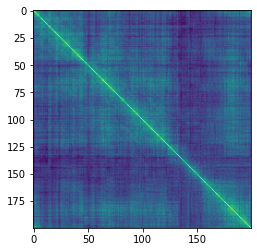

In [7]:
similarity_mats = []

for compressed_track in tqdm(compressed_tracks):
    
    ct_notes = []
    for measure in compressed_track:
        ct_notes.extend(measure)

    ints = np.array([f(note[0]) for note in ct_notes])
    # ints = np.array([note_to_int[note] for note in ct_notes])

    mat = np.ones((len(ints), len(ints))) * ints

    diff = mat - ints.reshape((-1, 1))

    #similarity = np.exp(-np.abs(diff) / len(note_to_int))
    similarity = np.exp(-np.abs(diff))
    
    similarity_mats.append(similarity)
    

SHAPE= (200, 200)
reshaped = np.array([cv.resize(m, SHAPE) for m in similarity_mats])

similarity_matrix = reshaped.mean(axis=0)
plt.imshow(similarity_matrix)

## Get some patterns in the data

In [8]:
vals, freq = np.unique([note_to_int[x] for x in notes], return_counts=True)

vals = np.array([int_to_note[x] for x in vals])
freq = 100 * freq / freq.sum()


sort_idx = freq.argsort()[::-1]

print('Top 15 most common values:')
print('[#Semitones, duration, isDotted]\n')
for idx in sort_idx[:15]:
    print(f'{vals[idx]} \t {freq[idx] :.1f}%')

Top 15 most common values:
[#Semitones, duration, isDotted]

['0' '8' 'False'] 	 17.1%
['0' '16' 'False'] 	 16.3%
['1' '8' 'False'] 	 4.1%
['3' '8' 'False'] 	 4.1%
['0_5' '8' 'False'] 	 3.7%
['1' '16' 'False'] 	 3.5%
['1_5' '8' 'False'] 	 2.9%
['0_5' '16' 'False'] 	 1.8%
['3_5' '8' 'False'] 	 1.7%
['2' '8' 'False'] 	 1.6%
['4' '16' 'False'] 	 1.2%
['4' '8' 'False'] 	 1.1%
['2' '16' 'False'] 	 1.0%
['1' '8' 'True'] 	 0.9%
['rest' '8' 'False'] 	 0.8%


## Calculate transition probabilities

In [9]:
ints = np.array([note_to_int[note] for note in notes])


transitions = np.zeros((n_vocab, n_vocab))

for x1, x2 in zip(ints[:-1], ints[1:]):
    transitions[x1, x2] += 1
    
transitions /= transitions.sum(axis=1, keepdims=True)
transitions = np.nan_to_num(transitions)

<ipython-input-9-c6c29efaff6b>:9: RuntimeWarning: invalid value encountered in true_divide
  transitions /= transitions.sum(axis=1, keepdims=True)


## Generate a song probabilistically

In [10]:
SONG_LENGTH = 200
song = np.zeros(SONG_LENGTH, dtype=object)

#song[0] = np.random.choice(sort_idx[:15])
song[0] = np.random.choice(len(freq), p=freq/100)

rng = np.random.default_rng()

In [11]:
for i in range(1, SONG_LENGTH):

    p = transitions[song[i-1]]
    potential_next_notes = np.where(p > 0)[0]
    
    errors = []

    for next_note in potential_next_notes:
        copy = np.copy(song)
        copy[i] = next_note


        ints = np.array([f(note) for note in copy[:i+1]])

        mat = np.ones((len(ints), len(ints))) * ints

        diff = mat - ints.reshape((-1, 1))

        #similarity = np.exp(-np.abs(diff) / len(note_to_int))
        similarity = np.exp(-np.abs(diff))

        template = similarity_matrix[:i+1, :i+1]

        rms = np.sqrt(np.mean(np.square(similarity - template)))
        errors.append(rms)

    
    #errors /= np.sum(errors)
    #p = 1 - np.array(errors)
        #p -= p.min()
        #p = p ** 5
    #p = p ** 5
    #p /= p.sum()
    #song[i] = rng.choice(potential_next_notes, p=p)
    
    choices = np.where(errors == np.min(errors))[0]
    song[i] = potential_next_notes[np.random.choice(choices)]
    
song = [int_to_note[num] for num in song]

In [12]:
'''
SONG_LENGTH = 200

song = np.zeros(SONG_LENGTH, dtype=object)

# Choose one of the top 15 notes as the starting note.
# TODO: weigh options by frequency!
song[0] = np.random.choice(sort_idx[:15])

for i in range(1, SONG_LENGTH):
    song[i] = np.random.choice(n_vocab, p=transitions[song[i-1]])
    
    
song = [int_to_note[x] for x in song]
print(song[0])
''';

## Convert Generated Song to 4/4 Time

In [13]:
def thirty_seconds_to_duration(count):
    if count % 3 == 0:
        # If the note is dotted, do 32 / (i * 2/3), and return isDotted = True.
        return (48//count, True)
    else:
        # If the note is not dotted, to 32 / i, and return isDotted = False.
        return (32//count, False)

def quantize_thirty_seconds(value):

    # 32nd-note values of each fundamental type of note (not including 64th-notes, of course).
    vals = np.array([32, # whole
                     24, # dotted half
                     16, # half
                     12, # dotted quarter
                     8,  # quarter
                     6,  # dotted eigth
                     4,  # eigth
                     3,  # dotted sixteenth
                     2,  # sixteenth
                     1]) # thirty-second
    
    list_out = []

    for v in vals:
        if v <= value:
            list_out.append(thirty_seconds_to_duration(v))
            value -= v
            
    return np.array(list_out)

In [14]:
# This will be the prediction output
new_prediction_output = []


time = 0
for beat in song:
    
    # Calculate the fraction of a measure encompassed by the current beat / chord.
    beat_time = (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    # Calculate the fraction of a measure taken up by all notes in the measure.
    # Calculate any residual time to see if this measure (in 4/4 time) is longer than 1 measure.
    measure_time = time + beat_time
    leftover_time = (measure_time) % 1
    
    # If the measure count (i.e., the measure integer) has changed and there is significant left-over beat time:
    if (int(measure_time) > int(time)) and (leftover_time > 1/128):
        
        # Calculate the initial 32nd notes encompassed by this beat in the current measure.
        this_measure_thirty_seconds = int(32 * (1 - time % 1))
        # Calculate the remaining 32nd notes encompassed by this beat in the next measure.
        next_measure_thirty_seconds = int(32 * leftover_time)
        
        # Get the Duration object parameters for this measure and the next measure.
        this_measure_durations = quantize_thirty_seconds(this_measure_thirty_seconds)
        next_measure_durations = quantize_thirty_seconds(next_measure_thirty_seconds)
        
        
        #print(f'{{ {32 / beat[1]}')
        for duration_idx, duration in enumerate(this_measure_durations):
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
                
            chord = beat[0] if duration_idx == 0 else 'tied'
            
            new_prediction_output.append((chord, duration[0], duration[1]))
            
            
        for duration in next_measure_durations:
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
            
            new_prediction_output.append(('tied', duration[0], duration[1]))
            
               
        continue
    
    
    time += beat_time
    new_prediction_output.append((beat[0], beat[1], beat[2]))
    
    #print(time, '\t', time * 32)


'''
time = 0
time2 = 0
idx = 0

for idx2, beat2 in enumerate(new_prediction_output[:100]):
    beat = prediction_output[idx]
    
    if time == time2:
        print(beat[0], '\t', time, '\t\t', beat2[0], '\t', time2)
        
        idx += 1
        
        time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    else:
        print('\t\t\t\t', beat2[0], '\t', time2)

    
    
    time2 += (1 / beat2[1]) * (1 + 0.5 * beat2[2])
''';

## Separate prediction output notes into measures

In [15]:
# Use the previously calculated cumulative time as the number of measures in the new 4/4 song.
num_measures = int(np.ceil(time))

song = np.empty(num_measures, dtype=object)

time = 0
m_idx = 0

timestamps = []

for beat in new_prediction_output:
    #print(time)
    timestamps.append(time)
    
    m_idx = int(time)
    
    if song[m_idx] is None:
        
        song[m_idx] = [beat]
    else:
        song[m_idx].append(beat)
    
    
    time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    
print(f'4/4 adjusted correctly: {set(range(num_measures)).issubset(set(timestamps))}')

4/4 adjusted correctly: True


## Write Song to.gp5 File

In [16]:
# Standard tuning
tuning = {1: MIDI['E4'],
          2: MIDI['B3'],
          3: MIDI['G3'],
          4: MIDI['D3'],
          5: MIDI['A2'],
          6: MIDI['E2']}

guitarpro.write(decompress_track(song, tuning), '_probabilistic_generation.gp5')
print('Finished')

Finished
